# Projet - ITK/VTK - Etude longitudinale de l’évolution d’une tumeur

In [1]:
import numpy as np
import itk
import matplotlib.pyplot as plt
import cv2
print(itk.Version.GetITKVersion())

5.3.0


In [2]:
# get the output image
images_1 = itk.imread("./Data/case6_gre1.nrrd")
images_2 = itk.imread("./Data/case6_gre2.nrrd")

images_1.shape, images_2.shape

((176, 256, 256), (176, 256, 256))

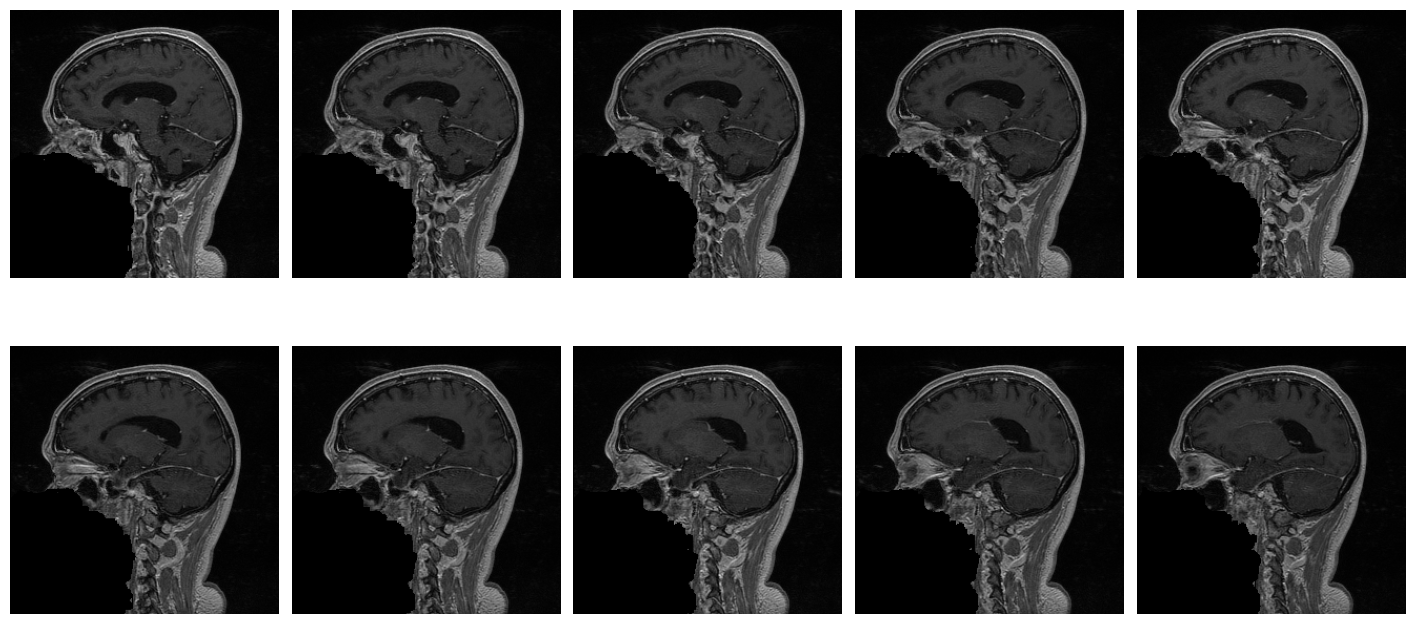

In [3]:
def print_10_slices(images, index_slice, dimension) :
    fig, axs = plt.subplots(2, 5, figsize=(18, 8))
    
    if dimension == 1 :
        if index_slice > images.shape[0] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 10 :
            limit += 1
            i += 1
        
        j = 0
        for i in range(index_slice, limit) :
            row = j // 5
            col = j % 5
            axs[row, col].imshow(images[i, :, :], cmap='gray')
            axs[row, col].axis('off')
            j += 1
    
    elif dimension >= 2 :
        if index_slice > images.shape[1] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 10 :
            limit += 1
            i += 1

        j = 0
        if dimension == 2 :
            for i in range(index_slice, limit) :
                row = j // 5
                col = j % 5
                axs[row, col].imshow(images[:, i, :], cmap='gray')
                axs[row, col].axis('off')
                j += 1
        else :
            for i in range(index_slice, limit) :
                row = j // 5
                col = j % 5
                axs[row, col].imshow(images[:, :, i], cmap='gray')
                axs[row, col].axis('off')
                j += 1
                
    plt.subplots_adjust(wspace=0.05)

print_10_slices(images_1, 100, 1)

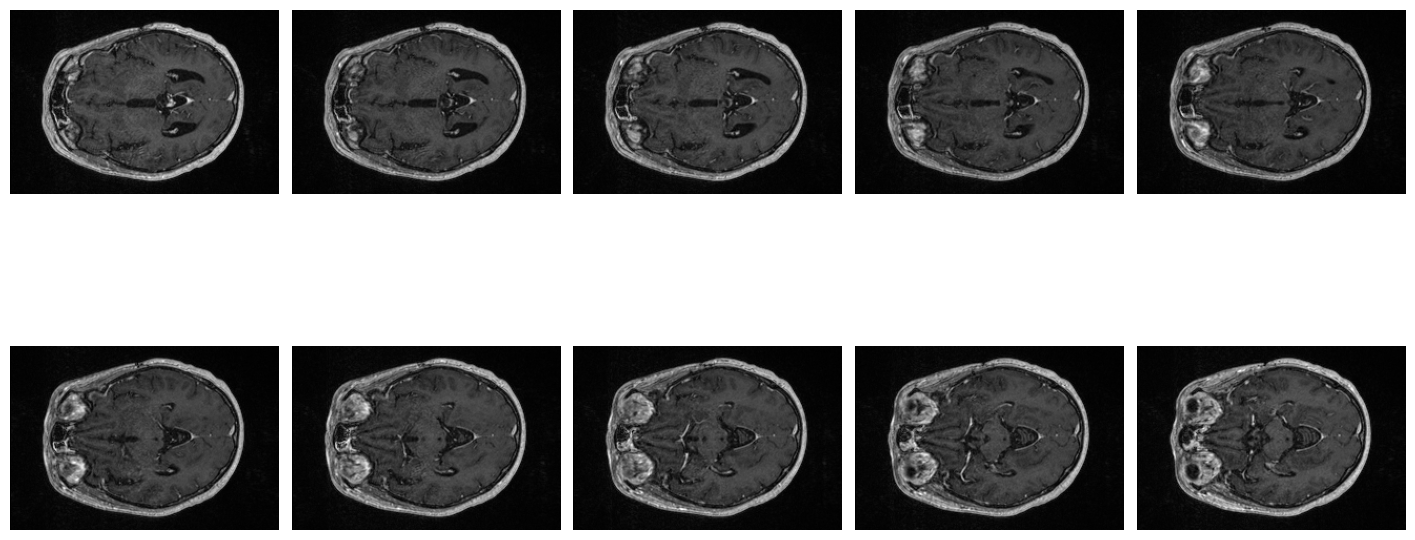

In [4]:
print_10_slices(images_1, 100, 2)

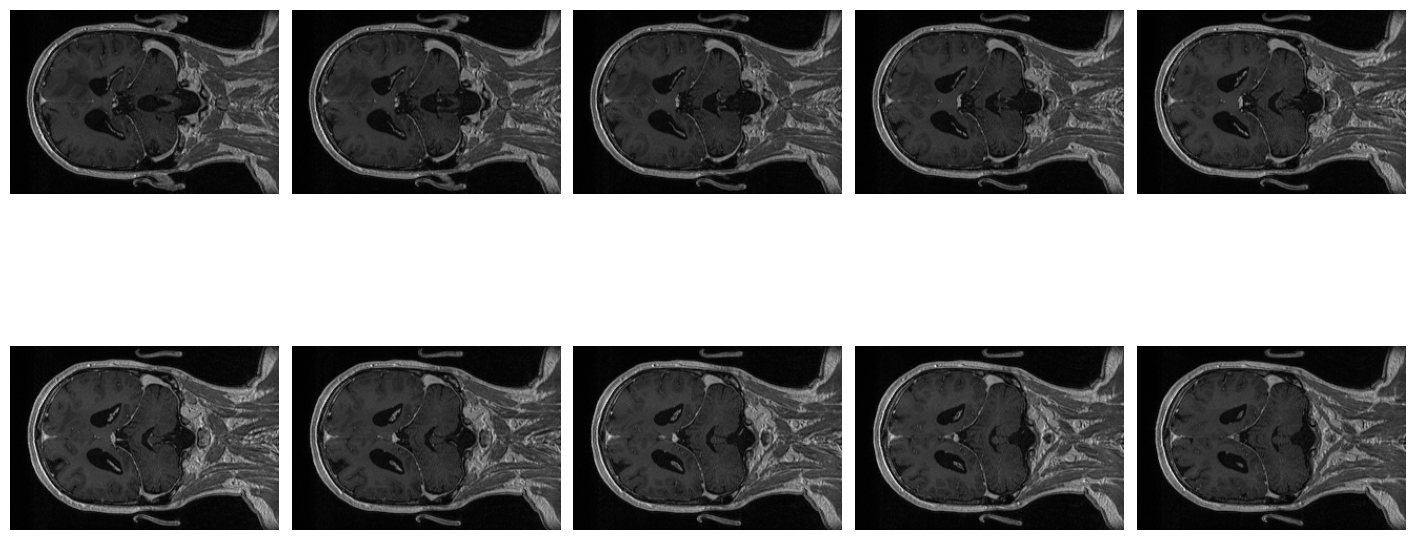

In [5]:
print_10_slices(images_1, 150, 3)

## Etape 1 - Recalage (juste sur le côté pour l'instant)

In [6]:
# Scale the uint16 images to the range [0, 255]
images_1_scaled = (images_1 / np.max(images_1)) * 255
images_1_scaled = np.clip(images_1_scaled, 0, 255).astype(np.uint8)
images_1_scaled.shape, images_1_scaled.dtype

images_2_scaled = (images_2 / np.max(images_2)) * 255
images_2_scaled = np.clip(images_2_scaled, 0, 255).astype(np.uint8)
images_2_scaled.shape, images_2_scaled.dtype

((176, 256, 256), dtype('uint8'))

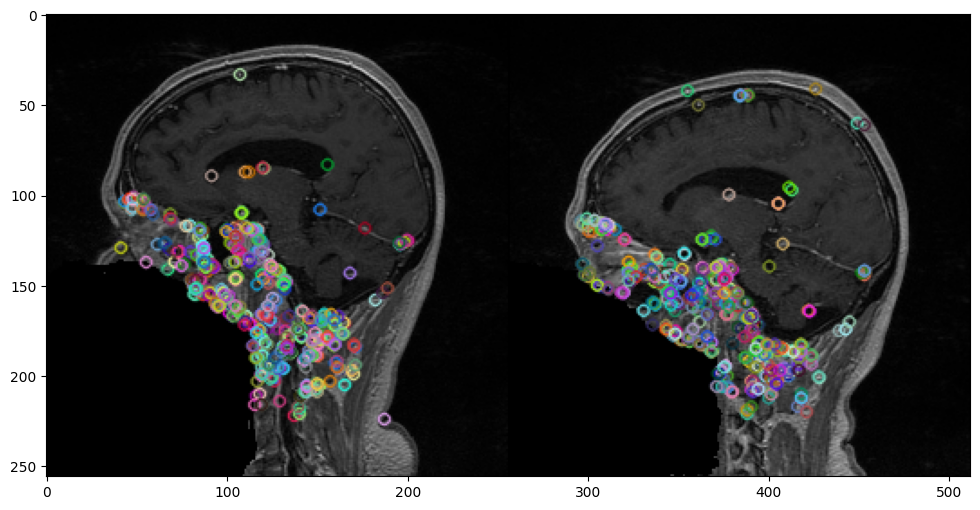

In [7]:
# Détection de 500 points clefs
orb = cv2.ORB_create(500)

keypoints_arr = []
descriptors_arr = []

for i in range(images_1.shape[0]) :
    keypoints1, descriptors1 = orb.detectAndCompute(images_1_scaled[i, :, :], mask=None)
    keypoints2, descriptors2 = orb.detectAndCompute(images_2_scaled[i, :, :], mask=None)
    
    keypoints_arr.append((keypoints1, keypoints2))
    descriptors_arr.append((descriptors1, descriptors2))

### Les lignes qui suivent ne sont là que pour permettre la visualisation des points clefs, 
### ce n'est pas du tout optimal
keypoints1_test, keypoints2_test = keypoints_arr[100]
descriptors1_test, descriptors2_test = descriptors_arr[100]

matcher2 = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
fauxm = matcher2.match(descriptors1_test, descriptors1_test, None)
im_keypoints1 = cv2.drawMatches(images_1_scaled[100, :, :], keypoints1_test, images_2_scaled[100, :, :], keypoints2_test, fauxm[0:0], None)

fig, axes = plt.subplots(1, figsize=(12, 6))
axes.imshow(im_keypoints1)

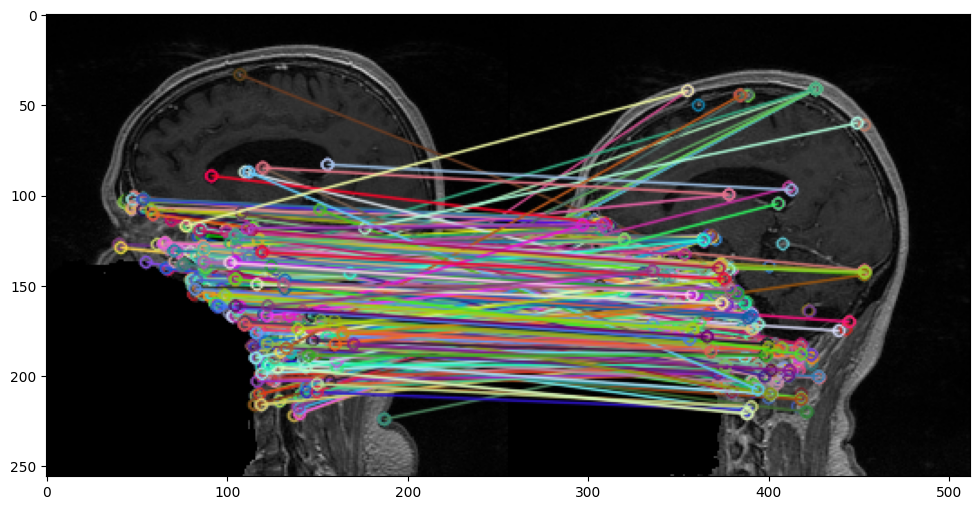

In [8]:
# Appariement de ces points clefs, utilisez ici la brute force
matcher = cv2.DescriptorMatcher.create(4) #...créez votre matcher ! DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING est très bien ici

matches = []

for i in range(len(descriptors_arr)) :
    descriptors1, descriptors2 = descriptors_arr[i]
    matches.append(matcher.match(descriptors1, descriptors2)) #...faites "matcher" les descripteurs
    
keypoints1_test, keypoints2_test = keypoints_arr[100]
# Visualisation des appariements
imMatches = cv2.drawMatches(images_1_scaled[100], keypoints1_test, images_2_scaled[100], keypoints2_test, matches[100], None)
fig, axes = plt.subplots(1, figsize=(12, 6))
axes.imshow(imMatches)

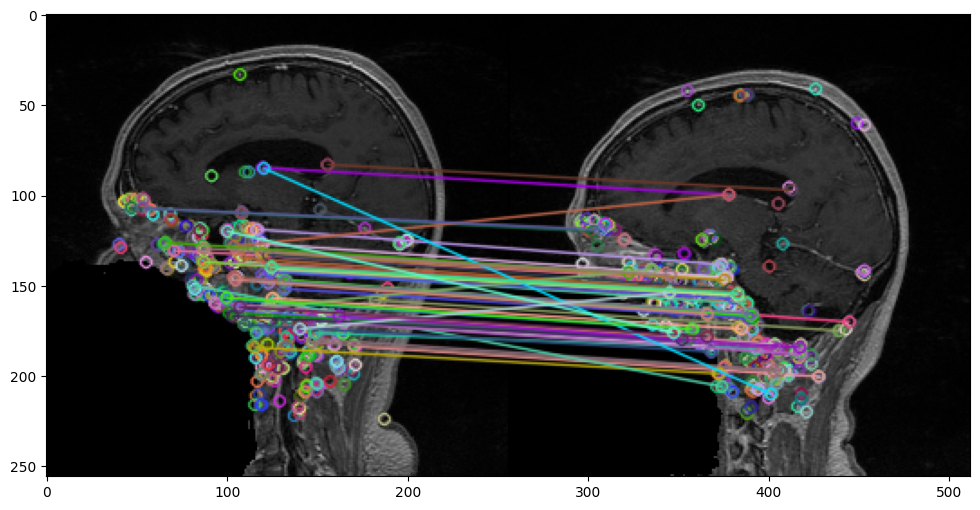

In [9]:
# Classement en fonction des scores
matches_sorted = [sorted(match, key=lambda match: match.distance) for match in matches]

# Sélection des meilleurs : on sélectionne les 15% les mieux appareillés
numGoodMatches = [len(match_sorted) * 0.15 for match_sorted in matches_sorted]

matches_reduced = []
for i in range(len(matches_sorted)) :
    matches_reduced.append(np.array(matches_sorted[i])[:int(numGoodMatches[i])]) #...on réduit la liste en prenant les 15% premiers
 
keypoints1, keypoints2 = keypoints_arr[100]
# Visualisation des appariements
imMatches = cv2.drawMatches(images_1_scaled[100], keypoints1, images_2_scaled[100], keypoints2, matches_reduced[100], None)
fig, axes = plt.subplots(1, figsize=(12, 6))
axes.imshow(imMatches)

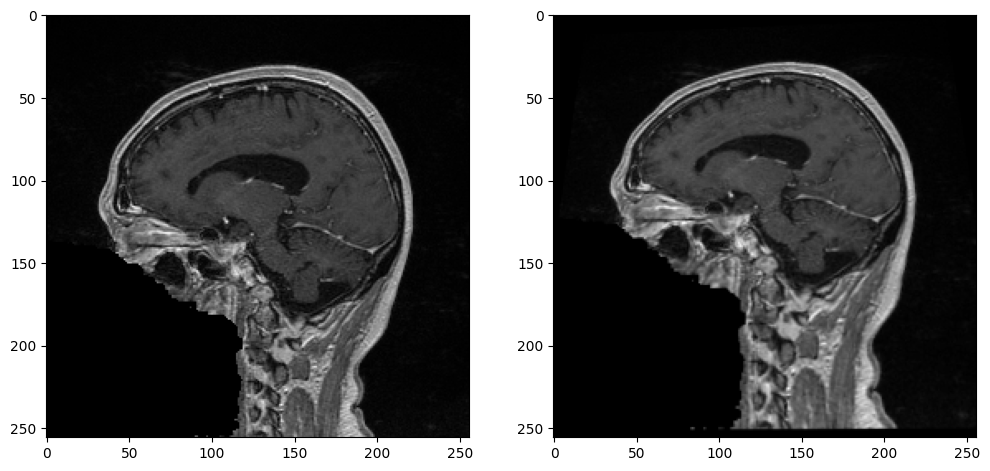

In [10]:
images_2_rescaled = []

for i in range(len(matches_reduced)) :
    keypoints1, keypoints2 = keypoints_arr[i]
    
    points1 = np.array([keypoints1[match.queryIdx].pt for match in matches_reduced[i]])
    points2 = np.array([keypoints2[match.trainIdx].pt for match in matches_reduced[i]])

    if (len(matches_reduced[i]) > 0 and len(points1) >= 4 and len(points2) >= 4) :
        # Calcul de l'homographie pour passer de points1 a points2, à l'aide de RANSAC
        h, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

        if (h is not None) :
            # Application de l'homographie,il s'agit d'une application de type perspective ici
            img_rescaled = cv2.warpPerspective(images_2_scaled[i, :, :], h, (images_2_scaled.shape[1], images_2_scaled.shape[2]))

            images_2_rescaled.append(img_rescaled)
        else :
            images_2_rescaled.append(images_2_scaled[i, :, :])
    
    else :
        images_2_rescaled.append(images_2_scaled[i, :, :])

images_2_rescaled = np.array(images_2_rescaled)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(images_2_scaled[100, :, :], cmap='gray')
axes[1].imshow(images_2_rescaled[100, :, :], cmap='gray')

In [11]:
images_2_rescaled.shape, images_2_rescaled.dtype

((176, 256, 256), dtype('uint8'))